## Homework 1

first download the data - 
you can just download it manually from the link, or use wget
be careful - don't unzip it locally and try to upload to colab - there are 10,000 files in the folder it will take forever to upload. first upload the zip to colab, then unzip.

In [1]:
!wget https://www.dropbox.com/s/apl6g5g9svhnfyg/Dataset.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!unzip Dataset.zip

in this homework you will build a classifier for the galaxy10 dataset (https://astronn.readthedocs.io/en/latest/galaxy10.html)

but its a "special" version of the dataset created for this homework. The images have been converted to grayscale, and saved as png files in two directories, "train" and "validation". There is a seperate test dataset in a secret location, you will train a model, submit it, and we will evaluate it on the test dataset

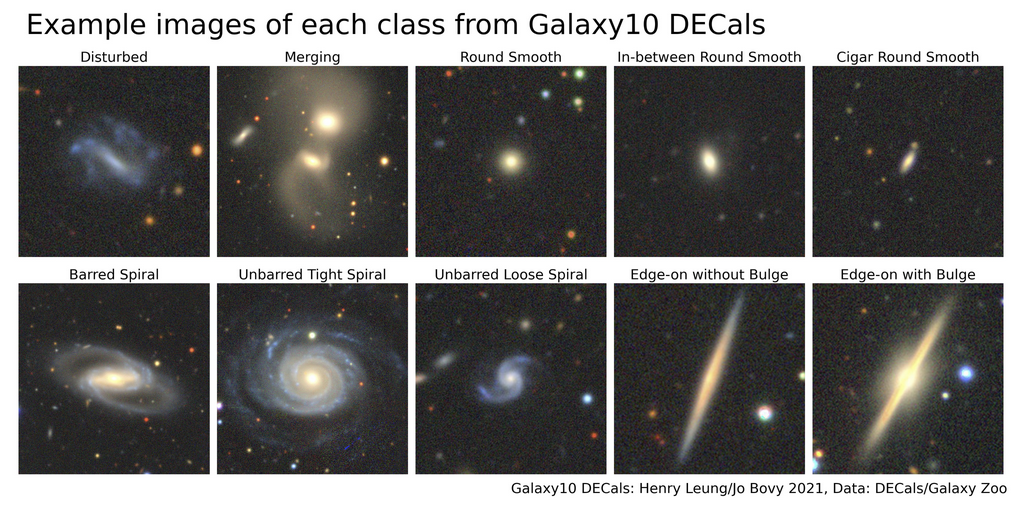

In [1]:
path_to_training_data = 'Dataset/train/'
path_to_validation_data = 'Dataset/validation/'

In [2]:
#first we get a list of the files in the directory

import glob
#glob gives you a list of file paths to the images
filelist = glob.glob(path_to_training_data+'/*.png')

#print the first 10 entries:
filelist[:10]

['Dataset/train\\class0_1023.png',
 'Dataset/train\\class0_1039.png',
 'Dataset/train\\class0_1043.png',
 'Dataset/train\\class0_1048.png',
 'Dataset/train\\class0_1051.png',
 'Dataset/train\\class0_1058.png',
 'Dataset/train\\class0_1065.png',
 'Dataset/train\\class0_1068.png',
 'Dataset/train\\class0_1073.png',
 'Dataset/train\\class0_1074.png']

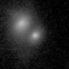

In [3]:
#to load a single image, use the PIL (python image library) function Image
from PIL import Image

Image.open(filelist[2])

In [4]:
#we want to turn it into a pytorch tensor, 
#and flatten it (since we want to train a fully connceted network)
# conda install torchvision -c pytorch
from torchvision import datasets, transforms

img = Image.open(filelist[0])

transforms.ToTensor()( img )

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0039],
         [0.0078, 0.0039, 0.0000,  ..., 0.0118, 0.0118, 0.0039],
         [0.0118, 0.0078, 0.0039,  ..., 0.0275, 0.0196, 0.0078],
         ...,
         [0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0157, 0.0196, 0.0157,  ..., 0.0000, 0.0000, 0.0000]]])

In [5]:
transforms.ToTensor()( img ).view(-1)

tensor([0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000])

In [6]:
#to determine the class label of an image, just look at its name:

filelist[:5]

['Dataset/train\\class0_1023.png',
 'Dataset/train\\class0_1039.png',
 'Dataset/train\\class0_1043.png',
 'Dataset/train\\class0_1048.png',
 'Dataset/train\\class0_1051.png']

In [7]:
## we generate numerical labels based on the file name
import torch
import numpy as np

labels = np.zeros(len(filelist))

for class_i in range(10):
    files_that_are_of_this_class = ['class'+str(class_i) in x for x in filelist]
    labels[ files_that_are_of_this_class ] = class_i
    
#the labels need to be converted to torch.LongTensor for multi-class classification
#see the documentation at https://pytorch.org/docs/stable/nn.html#crossentropyloss
labels = torch.LongTensor(labels)

labels

tensor([0, 0, 0,  ..., 9, 9, 9])

### ------------ HM FROM HERE ------------
### activate autoreload so any changes you make to dataloader.py, model.py are automatically imported

In [8]:
%load_ext autoreload
%autoreload 2

## now, write a custom dataloader for the dataset 



In [3]:
from dataloader import CustomDataset



## you should get something that works like this:

In [4]:
training_ds = CustomDataset(path_to_training_data, transform=False)
validation_ds = CustomDataset(path_to_validation_data)


some_random_idx = 9500
x,y=training_ds[some_random_idx]
print(x)
print(y)

tensor([0.0000, 0.0039, 0.0118,  ..., 0.0000, 0.0000, 0.0039])
tensor(8)


## now create the data loaders, and set the batch size. 
remember to shuffle the training dataset

In [11]:
from torch.utils.data import Dataset, DataLoader

training_dataloader = DataLoader(training_ds,batch_size=300,shuffle=True)
valid_dataloader = DataLoader(validation_ds,batch_size=300)

In [12]:
for x,y in training_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([300, 4761]) torch.Size([300])


## lets plot some examples from each class

this should work if your dataloader is implemented properly

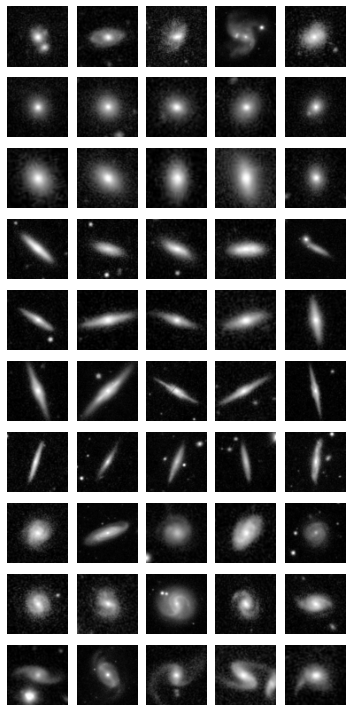

In [13]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(10,5,figsize=(5,10))


for class_i in range(10):
    idxs = np.where( training_ds.labels == class_i )[0]
    idxs = np.random.permutation(idxs)
    for plot_i in range(np.min([5,len(idxs)])):

        ax[class_i][plot_i].imshow(training_ds[idxs[plot_i]][0].reshape(69,69),cmap='gray')
        ax[class_i][plot_i].set_axis_off()
        
plt.tight_layout()
plt.show()

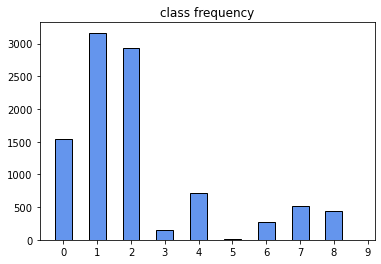

In [14]:
plt.hist(training_ds.labels.data.numpy(),bins=np.linspace(0,9,19)-0.25,color='cornflowerblue',ec='k')
plt.xticks(np.arange(10))
plt.title('class frequency')
plt.show()

# Now lets build the neural network

its a classifier - it takes as input 69*69 numbers, and outputs 10 numbers

In [15]:
from model import Net

In [16]:
net = Net()

## check your model takes the input and returns the right shape for the output.
should be (Batch size, 10) for the 10 classes

In [17]:
for x,y in training_dataloader:
    print(x.shape,net(x).shape,y.shape)
    break

torch.Size([300, 4761]) torch.Size([300, 10]) torch.Size([300])


## the training:


In [18]:
import torch.nn as nn
import torch.optim as optim


loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) 

In [19]:
def compute_accuracy_and_loss(dataloader,net):
    total = 0
    correct = 0
    
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for x,y in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            pred = net(x)  # This is a vector of size 10 (all probabilities that x belongs to that class)
            
            loss+= loss_func(pred,y).item()
            
            pred = torch.argmax(pred,dim=1)  # Consider only the highest-ranked class.

            correct+=len(torch.where(pred==y)[0])  # Count the correct predictions.
            total+=len(y)
            
    loss = loss/n_batches      
    return correct/total, loss  # Accuracy = correct predictions / total predictions.

In [26]:
compute_accuracy_and_loss(training_dataloader,net)  # We excpect low accuracy since the net is not trained.

(0.8791, 0.3791418732965694)

In [27]:
compute_accuracy_and_loss(valid_dataloader,net)  # likewise, but for the validation dataset.

(0.6598, 1.1009217605871313)

### fill out the missing parts of the training loop

remember, you need to zero the gradient, compute the loss, compute the gradient, then tell the optimizer to take a "step". when looping over the validation dataset you don't need to compute the loss and you don't need the optimizer - just compute the loss to see when to save your model.

In [22]:
from tqdm import tqdm

if torch.cuda.is_available():
    net.cuda()

In [23]:

n_epochs = 50


training_loss_vs_epoch = []
validation_loss_vs_epoch = []

training_acc_vs_epoch = []
validation_acc_vs_epoch = []

pbar = tqdm( range(n_epochs) )

for epoch in pbar:
    
    if len(validation_loss_vs_epoch) > 1:
        pbar.set_description('val acc:'+'{0:.5f}'.format(validation_acc_vs_epoch[-1])+
                             ', train acc:'+'{0:.5f}'.format(training_acc_vs_epoch[-1]))
    
    
    ### Train the model.
    net.train() # put the net into "training mode"
    for x,y in training_dataloader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            
        # add the basic training loop here
        optimizer.zero_grad()  # Set gradient to 0.
        
        output = net(x)  # Feed forward.
        loss = loss_func(output,y)  # Loss calculation (y is the target)
        
        loss.backward()  # Gradient calculation.
        optimizer.step()  # Model weight modification based on the optimizer.
    
    
    ### Validate the model. This is done within "compute_accuracy_and_loss()".
    net.eval() #put the net into evaluation mode

    
    # Compute and save accuracy and loss for both training and validation datasets.
    train_acc, train_loss = compute_accuracy_and_loss(training_dataloader,net)
    valid_acc, valid_loss =  compute_accuracy_and_loss(valid_dataloader,net)
         
    training_loss_vs_epoch.append( train_loss)    
    training_acc_vs_epoch.append( train_acc )
    
    validation_acc_vs_epoch.append(valid_acc)
    validation_loss_vs_epoch.append(valid_loss)
    
    #save the model if the validation loss has decreased
    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
        torch.save(net.state_dict(), 'trained_model.pt')
    
    
    

val acc:0.67020, train acc:0.86560: 100%|██████████| 50/50 [13:27<00:00, 16.15s/it]


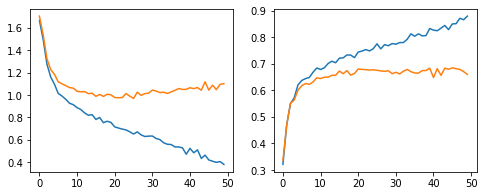

In [24]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(training_loss_vs_epoch,label='training')  # in blue. (decreases)
ax[0].plot(validation_loss_vs_epoch,label='validation')  # in orange (once over-trained, start to increase)

ax[1].plot(training_acc_vs_epoch)  # in blue (accuracy increases)
ax[1].plot(validation_acc_vs_epoch)  # in orange (once over-trained, reaching a plateau)

plt.show()

### optional: add data augmentation


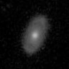

In [136]:
img = Image.open(filelist[443])
img

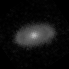

In [137]:
img = transforms.RandomRotation(180)( img )
img

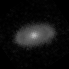

In [138]:
img

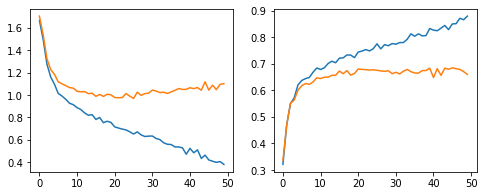

In [25]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(training_loss_vs_epoch,label='training')
ax[0].plot(validation_loss_vs_epoch,label='validation')

ax[1].plot(training_acc_vs_epoch)
ax[1].plot(validation_acc_vs_epoch)

plt.show()